<img src="https://www.metu.edu.tr/system/files/logo_orj/5/5.4.jpg" width="400" alt="Weights & Biases" />

# <font color='RED'>**Mayo Endoscopic Score Classification**</font>

Prepared by *Engin Deniz Erkan*

## Necessary Libraries

In [ ]:
pip install torch torchvision

In [ ]:
!pip install wandb -Uq

In [ ]:
!pip install timm

In [ ]:
pip install transformers

In [5]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torchvision.models as models
from torchvision.models import vit_b_16
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import random
from collections import Counter
import wandb
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data import Dataset
import timm

## Read Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!7z x '/content/drive/MyDrive/DI725_TermProject/train_and_validation_sets.zip' -o'/content/'

!7z x '/content/drive/MyDrive/DI725_TermProject/test_set.zip' -o'/content/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/DI725_TermProject/                                                   1 file, 1637567731 bytes (1562 MiB)

Extracting archive: /content/drive/MyDrive/DI725_TermProject/train_and_validation_sets.zip
 42% 4096 Open              --
Path = /content/drive/MyDrive/DI725_TermProject/train_and_validation_sets.zip
Type = zip
Physical Size = 1637567731

  0%      0% 57 - train_and_validation_sets/Mayo 0/UC_patient_107_23.bmp                                                                

### Directory paths for train/validation and test sets

In [8]:
train_val_dir = '/content/train_and_validation_sets'
test_dir = '/content/test_set'

## Exploratory Data Analysis (EDA)

### Statistics about the dataset

In [ ]:
# Function to get statistics about the dataset
def get_dataset_stats(directory):
    stats = []
    for class_dir in sorted(os.listdir(directory)):  # Sort sub-files alphabetically
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            example_image = cv2.imread(os.path.join(class_path, os.listdir(class_path)[0]))
            image_size = example_image.shape[:2]
            image_format = os.path.splitext(os.listdir(class_path)[0])[1]
            total_size = sum(os.path.getsize(os.path.join(class_path, f)) for f in os.listdir(class_path)) / (1024 * 1024) # Calculate total size in MB
            stats.append([class_dir, num_images, image_size, image_format, f"{total_size:.2f} MB"])
    return stats

# Get statistics for train/validation and test sets
train_val_stats = get_dataset_stats(train_val_dir)
test_stats = get_dataset_stats(test_dir)

# Display statistics in table format
print("\033[1m\033[91mTraining/Validation Dataset Statistics:\033[0m")
print(tabulate(train_val_stats, headers=["\033[1m\033[94mSub-file", "Number of Images", "Image Size", "Image Format", "Total Size\033[0m"], tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center")))
print("\n\033[1m\033[91mTest Dataset Statistics:\033[0m")
print(tabulate(test_stats, headers=["\033[1m\033[94mSub-file", "Number of Images", "Image Size", "Image Format", "Total Size\033[0m"], tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center")))


Training/Validation Dataset Statistics:
╒════════════╤════════════════════╤══════════════╤════════════════╤══════════════╕
│  Sub-file  │  Number of Images  │  Image Size  │  Image Format  │  Total Size  │
╞════════════╪════════════════════╪══════════════╪════════════════╪══════════════╡
│   Mayo 0   │        5180        │  (288, 352)  │      .bmp      │  1502.67 MB  │
├────────────┼────────────────────┼──────────────┼────────────────┼──────────────┤
│   Mayo 1   │        2588        │  (288, 352)  │      .bmp      │  750.75 MB   │
├────────────┼────────────────────┼──────────────┼────────────────┼──────────────┤
│   Mayo 2   │        1077        │  (288, 352)  │      .bmp      │  312.43 MB   │
├────────────┼────────────────────┼──────────────┼────────────────┼──────────────┤
│   Mayo 3   │        745         │  (288, 352)  │      .bmp      │  216.12 MB   │
╘════════════╧════════════════════╧══════════════╧════════════════╧══════════════╛

Test Dataset Statistics:
╒════════════╤═══════

### Visualizion of sample images from each class

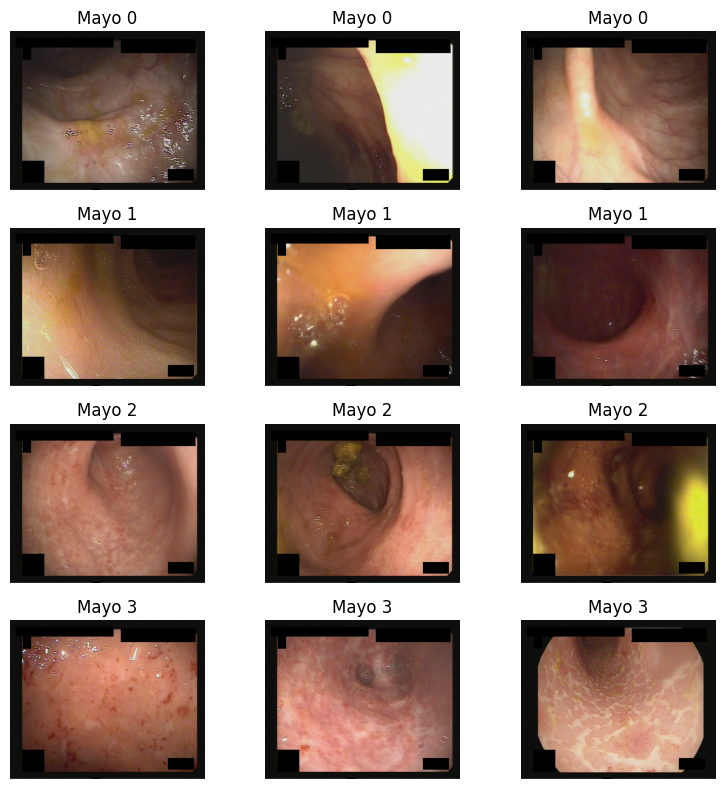

In [31]:
# Load and explore the dataset
def load_dataset(directory):
    image_paths = []
    labels = []
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_dir)
    return image_paths, labels

# Load train/validation dataset
train_val_image_paths, train_val_labels = load_dataset(train_val_dir)

# Load test dataset
test_image_paths, test_labels = load_dataset(test_dir)

# Visualize sample images from each class
def visualize_samples(image_paths, labels, num_samples=3):
    classes = np.unique(labels)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(8, 8))
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(labels) if label == class_name]
        sample_indices = random.sample(class_indices, num_samples)
        for j, idx in enumerate(sample_indices):
            image = cv2.imread(image_paths[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(image)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_val_image_paths, train_val_labels)

### Pixel Intensity Distribution

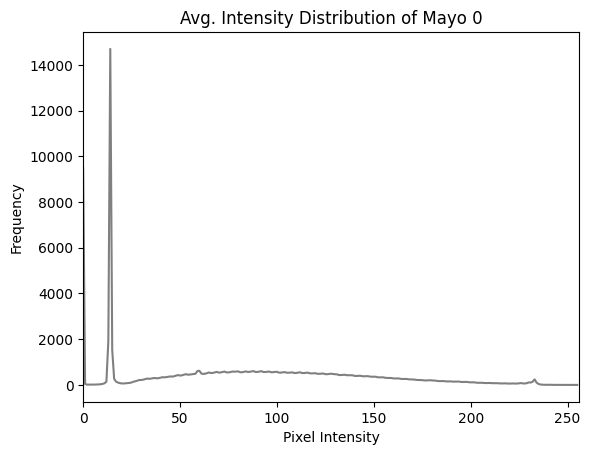

Maximum Pixel Intensity for Mayo 0: 14 (Frequency: 14698.025675675675)


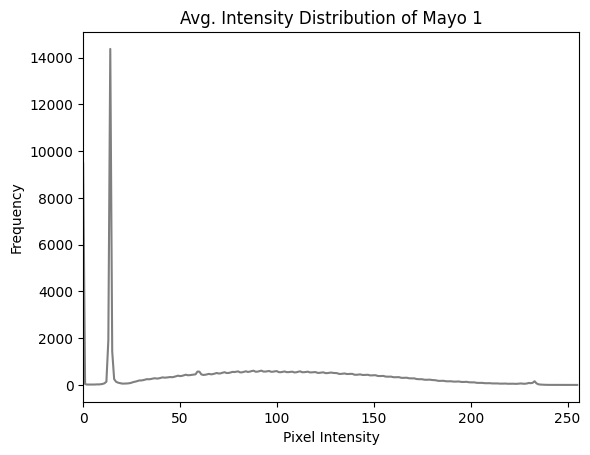

Maximum Pixel Intensity for Mayo 1: 14 (Frequency: 14375.625193199381)


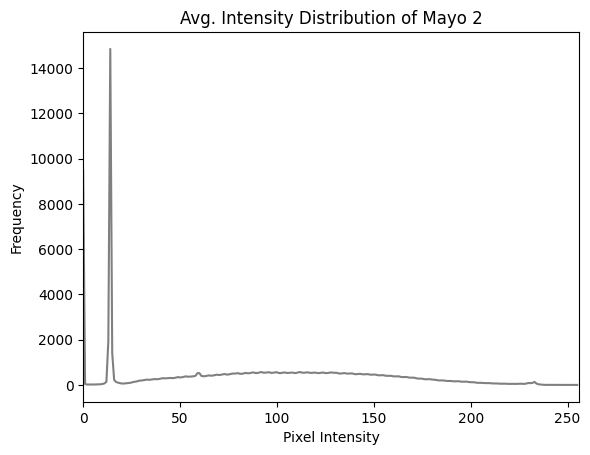

Maximum Pixel Intensity for Mayo 2: 14 (Frequency: 14852.128133704735)


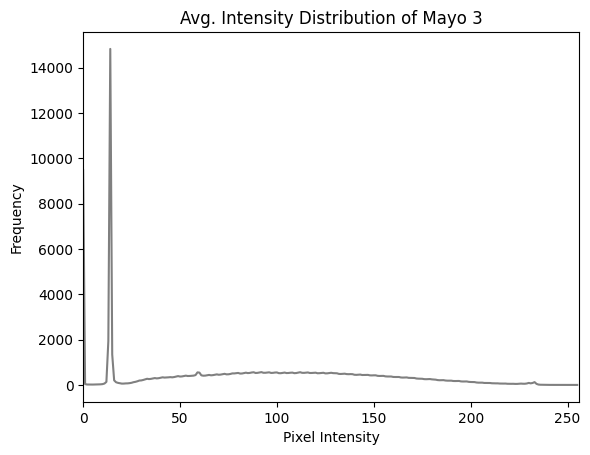

Maximum Pixel Intensity for Mayo 3: 14 (Frequency: 14829.547651006711)


In [ ]:
def plot_average_intensity_for_all_classes(image_paths, labels):
    classes = np.unique(labels)
    for class_name in classes:
        class_indices = [idx for idx, label in enumerate(labels) if label == class_name]
        intensity_sum = np.zeros(256)
        total_images = 0
        max_intensity = 0
        max_frequency = 0
        for idx in class_indices:
            image = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)
            intensity_histogram = np.histogram(image.ravel(), bins=256, range=[0, 256])[0]
            intensity_sum += intensity_histogram
            total_images += 1
        if total_images > 0:
            average_intensity = intensity_sum / total_images
            max_frequency_index = np.argmax(average_intensity)
            max_frequency = average_intensity[max_frequency_index]
            max_intensity = max_frequency_index
            plt.plot(average_intensity, color='gray')
            plt.title(f"Avg. Intensity Distribution of {class_name}")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")
            plt.xlim([0, 256])
            plt.show()
            print(f"Maximum Pixel Intensity for {class_name}: {max_intensity} (Frequency: {max_frequency})")
        else:
            print(f"No images found for class {class_name}")

plot_average_intensity_for_all_classes(train_val_image_paths, train_val_labels)



The average pixel intensity value that appears the most frequently throughout the images of a certain class is represented by each "Maximum Pixel Intensity".

"Frequency" describes how often the detected pixel intensity occurs in the class's image data.

The results show that the same maximum pixel intensity value of 14 is seen in all classes. Nonetheless, there are tiny variations in the corresponding frequencies, indicating slight differences in the pixel intensity distribution between the classes.

## Baseline Model (RESNET 18)

### Data Preprocessing

In [20]:
# Transformations for data preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            for image_file in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, image_file))
                self.labels.append(i)  # Use class index as label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# Create datasets
train_val_dataset = CustomDataset(train_val_dir, transform=train_transform)
test_dataset = CustomDataset(test_dir, transform=test_transform)

# Ratio of training and validation data
train_ratio = 0.8
val_ratio = 1 - train_ratio

# Calculate the sizes of training and validation sets
train_size = int(train_ratio * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Convert datasets to PyTorch DataLoader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

### Training Model

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


Epoch 1/25, Train Loss: 1.1275, Validation Loss: 0.8409
Epoch 2/25, Train Loss: 0.7677, Validation Loss: 0.7258
Epoch 3/25, Train Loss: 0.6860, Validation Loss: 0.7022
Epoch 4/25, Train Loss: 0.6439, Validation Loss: 0.6736
Epoch 5/25, Train Loss: 0.6276, Validation Loss: 0.6632
Epoch 6/25, Train Loss: 0.5964, Validation Loss: 0.6536
Epoch 7/25, Train Loss: 0.5793, Validation Loss: 0.6477
Epoch 8/25, Train Loss: 0.5526, Validation Loss: 0.6491
Epoch 9/25, Train Loss: 0.5365, Validation Loss: 0.6226
Epoch 10/25, Train Loss: 0.5291, Validation Loss: 0.6354
Epoch 11/25, Train Loss: 0.5058, Validation Loss: 0.6130
Epoch 12/25, Train Loss: 0.4930, Validation Loss: 0.6254
Epoch 13/25, Train Loss: 0.4782, Validation Loss: 0.6285
Epoch 14/25, Train Loss: 0.4703, Validation Loss: 0.6105
Epoch 15/25, Train Loss: 0.4482, Validation Loss: 0.6010
Epoch 16/25, Train Loss: 0.4377, Validation Loss: 0.6233
Epoch 17/25, Train Loss: 0.4171, Validation Loss: 0.6251
Epoch 18/25, Train Loss: 0.4111, Validat

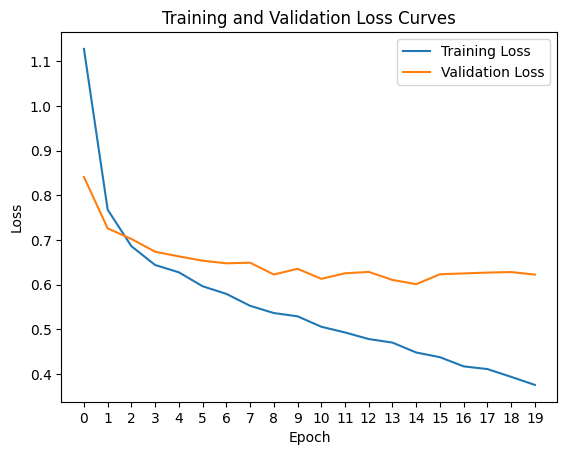

In [21]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")  # Device being used

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet18(x)
        return x

# Initialize the ResNet18 model
num_classes = 4
resnet18_model = ResNet18(num_classes)

# Move model to GPU if available
resnet18_model = resnet18_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.00001)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop

num_epochs = 25

# Early stopping parameters
patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

# Training loop with early stopping
for epoch in range(num_epochs):
    resnet18_model.train()  # Training mode
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = resnet18_model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        running_train_loss += loss.item() * images.size(0)

    # Calculate average training loss
    train_loss = running_train_loss / len(train_dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move data to GPU
            val_outputs = resnet18_model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_images.size(0)

    # Calculate average validation loss
    val_loss = val_running_loss / len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

# Plotting the data
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.xticks(range(len(train_losses))) # Setting ticks of x-axis to integers
plt.legend()
plt.show()

### Evaluation on validation and test sets

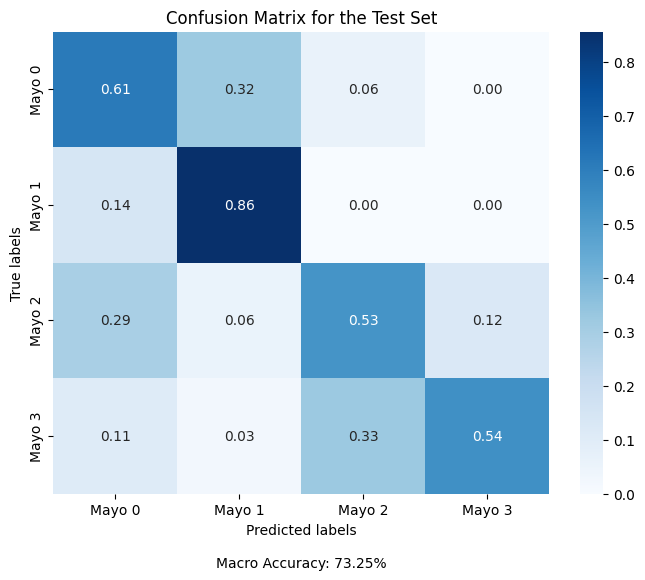

In [23]:
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    mae = mean_absolute_error(all_labels, all_predictions)
    kappa = cohen_kappa_score(all_labels, all_predictions, weights='quadratic')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    macro_accuracy = accuracy_score(all_labels, all_predictions)

    if dataloader == test_loader:

      # Confusion matrix
      cm = confusion_matrix(all_labels, all_predictions)
      cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

      classes = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']

      plt.figure(figsize=(8, 6))
      sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
      plt.xlabel('Predicted labels')
      plt.ylabel('True labels')
      plt.title('Confusion Matrix for the Test Set')
      plt.text(0.5, -0.15, "Macro Accuracy: {:.2f}%".format(macro_accuracy * 100), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
      plt.show()

    return mae, kappa, f1, macro_accuracy

# Evaluation on validation set
val_mae, val_kappa, val_f1, val_macro_acc = evaluate_model(resnet18_model, val_loader)

# Evaluation on test set
test_mae, test_kappa, test_f1, test_macro_acc = evaluate_model(resnet18_model, test_loader)

### Evaluation Metrics

In [24]:
table = [
    ["Metric", "Validation Set", "Test Set"],
    ["MAE", val_mae, test_mae],
    ["Quadratic Weighted Kappa", val_kappa, test_kappa],
    ["F1 Score (Macro)", val_f1, test_f1],
    ["Accuracy (Macro)", val_macro_acc, test_macro_acc]
]

print("\033[1m\033[91mResNet18 Statistics\033[0m")
print(tabulate(table, headers="firstrow", tablefmt='fancy_grid'))

ResNet18 Statistics
╒══════════════════════════╤══════════════════╤════════════╕
│ Metric                   │   Validation Set │   Test Set │
╞══════════════════════════╪══════════════════╪════════════╡
│ MAE                      │         0.315954 │   0.33274  │
├──────────────────────────┼──────────────────┼────────────┤
│ Quadratic Weighted Kappa │         0.664719 │   0.616622 │
├──────────────────────────┼──────────────────┼────────────┤
│ F1 Score (Macro)         │         0.686931 │   0.655201 │
├──────────────────────────┼──────────────────┼────────────┤
│ Accuracy (Macro)         │         0.749218 │   0.732503 │
╘══════════════════════════╧══════════════════╧════════════╛


## Naive Basline Model

In [28]:
# Function to find the most common class label
def find_most_common_class(labels):
    label_counts = Counter(labels)
    most_common_class = max(label_counts, key=label_counts.get)
    return most_common_class

# Most common class in the training/validation set
most_common_class = find_most_common_class(train_val_labels)

# Function to map labels to integers
def label_to_numeric(labels):
    unique_labels = sorted(set(labels))
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    numeric_labels = [label_to_id[label] for label in labels]
    return numeric_labels, label_to_id

# Convert all labels to numeric
train_val_numeric_labels, label_map = label_to_numeric(train_val_labels)
test_numeric_labels, _ = label_to_numeric(test_labels)

most_common_class_numeric = label_map[most_common_class]
test_predictions = [most_common_class_numeric] * len(test_labels)

# Function to calculate evaluation metrics
def evaluate_predictions(true_labels, predictions):
    mae = mean_absolute_error(true_labels, predictions)
    kappa = cohen_kappa_score(true_labels, predictions, weights='quadratic')
    f1 = f1_score(true_labels, predictions, average='macro')
    macro_accuracy = accuracy_score(true_labels, predictions)
    return mae, kappa, f1, macro_accuracy

# Evaluate the naive model with numeric labels
test_metrics = evaluate_predictions(test_numeric_labels, test_predictions)

# Display evaluation metrics in a tabular format
table = [
    ["Metric", "Test Set"],
    ["MAE", test_metrics[0]],
    ["Quadratic Weighted Kappa", test_metrics[1]],
    ["F1 Score (Macro)", test_metrics[2]],
    ["Accuracy (Macro)", test_metrics[3]]
]

print("\033[1m\033[91mNaive Model Statistics\033[0m")
print(tabulate(table, headers="firstrow", tablefmt='fancy_grid'))

Naive Model Statistics
╒══════════════════════════╤════════════╕
│ Metric                   │   Test Set │
╞══════════════════════════╪════════════╡
│ MAE                      │   0.698695 │
├──────────────────────────┼────────────┤
│ Quadratic Weighted Kappa │   0        │
├──────────────────────────┼────────────┤
│ F1 Score (Macro)         │   0.177135 │
├──────────────────────────┼────────────┤
│ Accuracy (Macro)         │   0.548636 │
╘══════════════════════════╧════════════╛


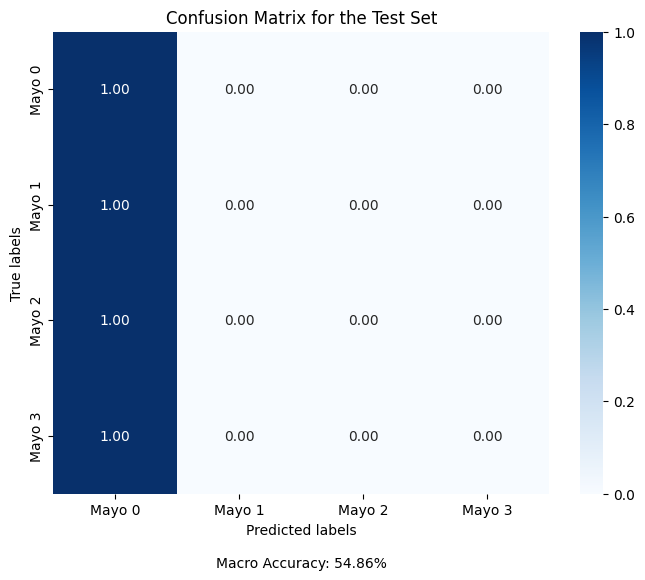

In [29]:
def plot_confusion_matrix_percentage(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    classes = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for the Test Set')

    # Calculate macro accuracy
    total_correct = np.trace(cm)
    total_samples = np.sum(cm)
    macro_accuracy = total_correct / total_samples

    # Place macro accuracy below x-axis label
    plt.text(0.5, -0.15, "Macro Accuracy: {:.2f}%".format(macro_accuracy * 100), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.show()

classes = sorted(set(test_labels))
plot_confusion_matrix_percentage(test_numeric_labels, test_predictions, classes)

## Transformer Model

### Data Preprocessing

In [10]:
# Directories
train_val_dir = '/content/train_and_validation_sets'
test_dir = '/content/test_set'

# Transformations for data preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            for image_file in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, image_file))
                self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# Splitting the datasets
train_val_dataset = CustomDataset(train_val_dir, transform=train_transform)
test_dataset = CustomDataset(test_dir, transform=test_transform)

# Ratio for splitting training and validation data
train_ratio = 0.8
train_size = int(train_ratio * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

### WandB Login

In [12]:
wandb.login()

wandb: Currently logged in as: engindenizerkan. Use `wandb login --relogin` to force relogin


True

### Training Model

In [13]:
# Define the Vision Transformer Model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        # Load the pre-trained DeiT model
        self.model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        # Replace the classification head
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Global variable to keep track of the best validation loss across all sweeps
global_best_val_loss = float('inf')
global_best_model_path = 'best_model_across_sweeps.pth'

def train_model(config=None):
    global global_best_val_loss

    with wandb.init(config=config):
        config = wandb.config

        # DataLoader
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

        # Initialize model, loss, and optimizer
        model = ViTModel(num_classes=len(os.listdir(train_val_dir))).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        best_val_loss = float('inf')
        patience = 5
        epochs_no_improve = 0


        for epoch in range(20):

            # Training phase
            model.train()
            train_loss = 0.0
            train_preds, train_labels = [], []

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * images.size(0)
                train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds, average='macro')
            train_mae = mean_absolute_error(train_labels, train_preds)
            train_kappa = cohen_kappa_score(train_labels, train_preds, weights='quadratic')

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_preds, val_labels = [], []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * images.size(0)
                    val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds, average='macro')
            val_mae = mean_absolute_error(val_labels, val_preds)
            val_kappa = cohen_kappa_score(val_labels, val_preds, weights='quadratic')

            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_kappa": train_kappa,
                "val_kappa": val_kappa,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "train_f1": train_f1,
                "val_f1": val_f1,
                "train_mae": train_mae,
                "val_mae": val_mae,
            })

            # Early stopping and save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f'Early stopping triggered at epoch {epoch}, Best Validation Loss: {best_val_loss}')
                    break

            # Check if this is the best model across all sweep configurations
            if best_val_loss < global_best_val_loss:
                global_best_val_loss = best_val_loss
                torch.save(model.state_dict(), global_best_model_path)

        print(f'Best validation loss for this configuration: {best_val_loss}')
        print(f'Best validation loss across all configurations: {global_best_val_loss}')

sweep_configuration = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'learning_rate': {'values': [1e-5, 1e-4, 1e-3]},
        'batch_size': {'values': [16, 32]},
    }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project='DI725-TermProject', entity='engindenizerkan')
wandb.agent(sweep_id, function=train_model, count=6)

Create sweep with ID: rty0zjfh
Sweep URL: https://wandb.ai/engindenizerkan/DI725-TermProject/sweeps/rty0zjfh


wandb: Agent Starting Run: o3bekse9 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:78: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_small_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:93: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Plea

Early stopping triggered at epoch 8, Best Validation Loss: 0.5015846655875973
Best validation loss for this configuration: 0.5015846655875973
Best validation loss across all configurations: 0.5015846655875973


epoch,▁▂▃▄▅▅▆▇█
train_accuracy,▁▄▅▅▆▆▇██
train_f1,▁▄▅▅▆▆▇██
train_kappa,▁▅▅▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁
train_mae,█▅▄▄▃▃▂▁▁
val_accuracy,▁▃▆▇▄▄███
val_f1,▁▃▇▇████▇
val_kappa,▁▄▇▇▇▇█▆█
val_loss,█▆▃▁▃▄▃▅▆
val_mae,█▅▂▂▃▄▂▂▁


wandb: Agent Starting Run: axtcs3z8 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Early stopping triggered at epoch 8, Best Validation Loss: 0.54116552971824
Best validation loss for this configuration: 0.54116552971824
Best validation loss across all configurations: 0.5015846655875973


epoch,▁▂▃▄▅▅▆▇█
train_accuracy,▁▃▄▅▅▆▇▇█
train_f1,▁▄▄▅▆▆▇▇█
train_kappa,▁▄▅▅▆▆▇▇█
train_loss,█▅▅▄▄▃▂▂▁
train_mae,█▆▅▄▄▃▂▂▁
val_accuracy,▁▄▆█▃▆█▃▅
val_f1,▁▄▅█▂▅█▃▆
val_kappa,▁▅▅█▅▆█▇▃
val_loss,▅▃▂▁▇▃▃█▇
val_mae,█▇▄▁▇▃▁▇▄


wandb: Agent Starting Run: 1uvgsnqc with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Early stopping triggered at epoch 17, Best Validation Loss: 1.100294252133096
Best validation loss for this configuration: 1.100294252133096
Best validation loss across all configurations: 0.5015846655875973


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_accuracy,▁▆▅▅█▅▅▇▅▆▆▆▇▅▇▆▇█
train_f1,▄▁▃▁▄▅▇▅▅▅▅▆▆▆▇▅█▇
train_kappa,▄█▆▆▆▄▃▂▂▁▄▆▆▁▃▂▄▃
train_loss,█▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁
train_mae,█▁▄▃▂▆█▅▇▆▆▇▅██▇█▇
val_accuracy,▆▆▆▆▆▆▆▆▆▅▆█▆▆▁▆▇▆
val_f1,▁▁▁▂▁▃▂▄▁▆▁▆▂▂█▁▂▃
val_kappa,▅▅▅▂▆▃▇▁▅▂▅█▆▆█▆▃▆
val_loss,▆▅█▄▃▂▃▂▆▅█▄▁▁█▁▂▆
val_mae,▁▁▁▂▁▂▁▂▁▄▁▂▁▁█▁▁▂


wandb: Agent Starting Run: eyljyta7 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 1e-05


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Early stopping triggered at epoch 10, Best Validation Loss: 0.5004970881314919
Best validation loss for this configuration: 0.5004970881314919
Best validation loss across all configurations: 0.5004970881314919


epoch,▁▂▂▃▄▅▅▆▇▇█
train_accuracy,▁▄▄▅▅▆▆▆▇▇█
train_f1,▁▄▅▅▆▆▆▇▇▇█
train_kappa,▁▅▅▆▆▆▇▇▇██
train_loss,█▅▄▄▃▃▃▂▂▁▁
train_mae,█▅▅▄▃▃▃▂▂▁▁
val_accuracy,▁▄▅▅█▇██▇█▇
val_f1,▁▃▄▄▆▆█▇▇█▇
val_kappa,▁▄█▇█▆▇█▆▇█
val_loss,█▅▃▂▁▁▁▂▂▄▆
val_mae,█▄▃▃▁▂▁▁▂▁▁


wandb: Agent Starting Run: upkmwg4z with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Early stopping triggered at epoch 8, Best Validation Loss: 0.5423867341375699
Best validation loss for this configuration: 0.5423867341375699
Best validation loss across all configurations: 0.5004970881314919


epoch,▁▂▃▄▅▅▆▇█
train_accuracy,▁▃▄▅▅▆▇▇█
train_f1,▁▃▄▅▅▆▇██
train_kappa,▁▄▄▅▅▇▇██
train_loss,█▆▅▄▄▃▂▂▁
train_mae,█▆▅▄▄▃▂▁▁
val_accuracy,▁▇▂█▃▄▂█▆
val_f1,▂▆▃▇▁▆▆█▅
val_kappa,▁▇▄█▂▇▇█▇
val_loss,▃▂▂▁▃▃█▆▇
val_mae,▇▄█▁▄▃▅▁▂


wandb: Agent Starting Run: 4x8x05dw with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Early stopping triggered at epoch 12, Best Validation Loss: 1.0834004775823964
Best validation loss for this configuration: 1.0834004775823964
Best validation loss across all configurations: 0.5004970881314919


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_accuracy,▁▅▆▆▆▇▅▆▆████
train_f1,▃▂▂▄▅▅▁▆▆▇▇██
train_kappa,▄▅▇▅▄█▄▃▁▁▃▄▄
train_loss,█▅▄▃▂▃▃▁▂▂▂▁▁
train_mae,█▃▁▃▆▃▂▆▇▆▅▅▆
val_accuracy,▂▄▃▂▂▂█▅▂▅▁▂▄
val_f1,▁▃▄▁▁▁▇▅▁▃▁▁█
val_kappa,██▁▇█▇█▃▇▅▇▆▂
val_loss,█▆▆▅▇▄▄▁▅▂▄▆▁
val_mae,▁▂▄▁▁▁▄▄▁▂▁▁█


### Evaluation on validation and test sets

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


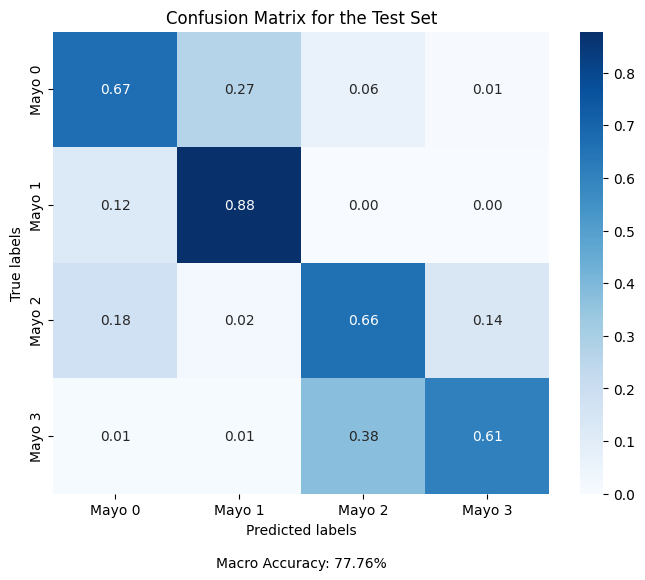

In [17]:
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    mae = mean_absolute_error(all_labels, all_predictions)
    kappa = cohen_kappa_score(all_labels, all_predictions, weights='quadratic')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    macro_accuracy = accuracy_score(all_labels, all_predictions)

    if dataloader == test_loader:

      # Confusion matrix
      cm = confusion_matrix(all_labels, all_predictions)
      cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

      classes = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']

      plt.figure(figsize=(8, 6))
      sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
      plt.xlabel('Predicted labels')
      plt.ylabel('True labels')
      plt.title('Confusion Matrix for the Test Set')
      plt.text(0.5, -0.15, "Macro Accuracy: {:.2f}%".format(macro_accuracy * 100), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
      plt.show()

    return mae, kappa, f1, macro_accuracy

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Initialize the model
best_model = ViTModel(num_classes=len(os.listdir(train_val_dir))).to(device)

# Load the weights of the best model
best_model.load_state_dict(torch.load('best_model_across_sweeps.pth'))

# Evaluation on validation set using the best model
val_mae, val_kappa, val_f1, val_macro_acc = evaluate_model(best_model, val_loader)

# Evaluation on test set using the best model
test_mae, test_kappa, test_f1, test_macro_acc = evaluate_model(best_model, test_loader)


In [18]:
table = [
    ["Metric", "Validation Set", "Test Set"],
    ["MAE", val_mae, test_mae],
    ["Quadratic Weighted Kappa", val_kappa, test_kappa],
    ["F1 Score (Macro)", val_f1, test_f1],
    ["Accuracy (Macro)", val_macro_acc, test_macro_acc]
]

print("\033[1m\033[91mData-efficient Image Transformers Statistics\033[0m")
print(tabulate(table, headers="firstrow", tablefmt='fancy_grid'))

Data-efficient Image Transformers Statistics
╒══════════════════════════╤══════════════════╤════════════╕
│ Metric                   │   Validation Set │   Test Set │
╞══════════════════════════╪══════════════════╪════════════╡
│ MAE                      │         0.27268  │   0.263938 │
├──────────────────────────┼──────────────────┼────────────┤
│ Quadratic Weighted Kappa │         0.738572 │   0.725913 │
├──────────────────────────┼──────────────────┼────────────┤
│ F1 Score (Macro)         │         0.730975 │   0.710441 │
├──────────────────────────┼──────────────────┼────────────┤
│ Accuracy (Macro)         │         0.773201 │   0.77758  │
╘══════════════════════════╧══════════════════╧════════════╛


### WandB Link

https://wandb.ai/engindenizerkan/DI725-TermProject